# 2

## 2.1

In [425]:
# Importing libraries
%matplotlib inline
import os
import cv2
import math
import random
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from google.colab.patches import cv2_imshow

### (i) Harris

In [426]:
def gaussian(ksize):
    sigma=1
    xx = np.arange(-ksize // 2 + 1.0, ksize // 2 + 1.0)
    a, b = np.meshgrid(xx, xx)
    kernel = np.exp(-(a*2 + b*2) / (2. * sigma*2))
    output=kernel / np.sum(kernel)
    return output


def harris_detector(image, kernal_size):
    
    c = []
    r = []
    rows = []
    cols = []
    xx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize = kernal_size)
    yy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize = kernal_size)
    Ixx = xx * xx
    Ixy = xx * yy
    Iyy = yy * yy
    
    kernel = gaussian(kernal_size)
    filt_xx = cv2.filter2D(Ixx, -1, kernel)
    filt_xy = cv2.filter2D(Ixy, -1, kernel)
    filt_yy = cv2.filter2D(Iyy, -1, kernel)

    output = np.zeros(filt_xx.shape)
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            filt = np.array([[filt_xx[i][j], filt_xy[i][j]], [filt_xy[i][j], filt_yy[i][j]]])
            pass
            output[i][j] = np.linalg.det(filt)-0.04*np.trace(filt)**2


    for i in range(0, output.shape[0] - kernal_size, kernal_size):
      for j in range(0, output.shape[1] - kernal_size, kernal_size):
          m = output[i:i + kernal_size, j:j + kernal_size]
          index = np.argmax(m)
          row = int(index / kernal_size) + i
          col = int(index % kernal_size) + j
          r.append(row)
          c.append(col)

    local_maxima = []
    for i in range(len(r)):
      local_maxima.append(output[r[i]][c[i]])
      pass
    num_corners=500
    ind = np.argpartition(local_maxima, -num_corners)[-num_corners:]
    for i in ind:
      rows.append(r[i])
      cols.append(c[i])

    return rows, cols




### (ii) Shi -Tomasi

In [427]:

def tomasi_detector(image, kernal_size):

    c = []
    r = []
    rows = []
    cols = []

    xx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize = kernal_size)
    yy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize = kernal_size)
   
    Ixx = xx * xx
    Ixy = xx * yy
    Iyy = yy * yy

    kernel = gaussian(kernal_size)
    filt_xx = cv2.filter2D(Ixx, -1, kernel)
    filt_xy = cv2.filter2D(Ixy, -1, kernel)
    filt_yy = cv2.filter2D(Iyy, -1, kernel)

    output = np.zeros(filt_xx.shape)

    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            filt = np.array([[filt_xx[i][j], filt_xy[i][j]], [filt_xy[i][j], filt_yy[i][j]]])
            # D, V = np.linalg.eig(filt)
            ww1 = np.trace(filt)
            ww2 = math.sqrt(np.trace(filt)**2-4*np.linalg.det(filt))
            # output[i][j] = np.linalg.det(filt)-0.04*np.trace(filt)**2
            output[i][j] = min((ww1+ww2)/2,(ww1-ww2)/2)


    for i in range(0, output.shape[0] - kernal_size, kernal_size):
        for j in range(0, output.shape[1] - kernal_size, kernal_size):
            m = output[i:i + kernal_size, j:j + kernal_size]
            index = np.argmax(m)
            row = int(index / kernal_size) + i
            col = int(index % kernal_size) + j
            r.append(row)
            c.append(col)

    local_maxima = []
    for i in range(len(r)):
        local_maxima.append(output[r[i]][c[i]])
    num_corners=500
    ind = np.argpartition(local_maxima, -num_corners)[-num_corners:]
    for i in ind:
        rows.append(r[i])
        cols.append(c[i])

    return rows, cols


def gaussian(ksize):
    sigma=1
    xx = np.arange(-ksize // 2 + 1.0, ksize // 2 + 1.0)
    a, b = np.meshgrid(xx, xx)
    kernel = np.exp(-(a*2 + b*2) / (2. * sigma*2))
    output=kernel / np.sum(kernel)
    return output

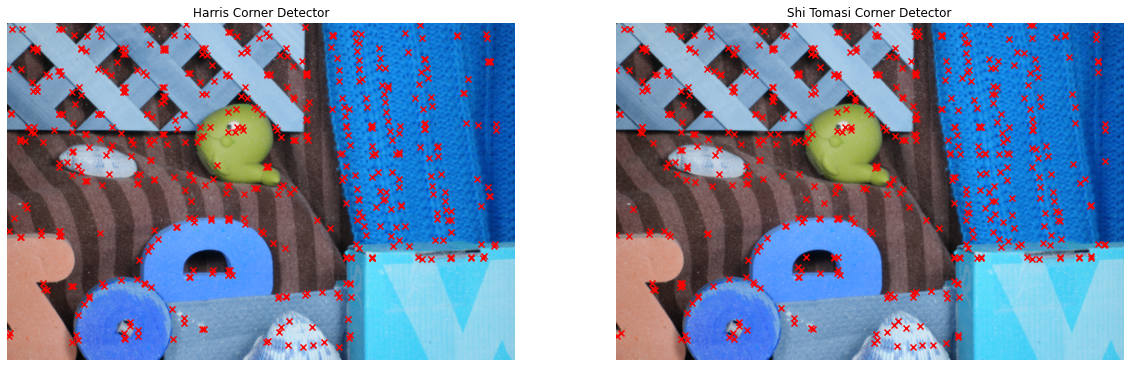

In [428]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(40)


plt.subplot(121)
frame07 = cv2.imread('/content/frame07.png',0)
corners = harris_detector(frame07,15)
frame07 = cv2.imread('/content/frame07.png')
plt.imshow(frame07)
plt.scatter(corners[1],corners[0], color='red',marker='x')
plt.title('Harris Corner Detector')
plt.axis('off')

plt.subplot(122)
frame07 = cv2.imread('/content/frame07.png',0)
corners = tomasi_detector(frame07,15)
frame07 = cv2.imread('/content/frame07.png')
plt.imshow(frame07)
plt.scatter(corners[1],corners[0], color='red',marker='x')
plt.title('Shi Tomasi Corner Detector')
plt.axis('off')

plt.show()

## 2.2

The main idea of this method based on a local motion constancy assumption, where nearby pixels have the same displacement direction. This assumption helps to get the approximated solution for the equation with two variables.
Let us assume that the neighboring pixels have the same motion vector $(\Delta x, \Delta y)$. We can take a fixed-size window to create a system of equations. Let $p_i$ = $(x_i, y_i)$ be the pixel coordinates in the chosen window of N elements . 

In [429]:
def LukasKanadeForwardAdditive(Img1, Img2, windowSize):
    threshold=0.01

    w = windowSize # windowSize is odd, all the pixels with offset in between [-w, w] are inside the window
    Img1 = Img1 / 255. # normalize pixels
    Img2 = Img2 / 255. # normalize pixels
    # Implement Lucas Kanade
    # for each point, calculate I_x, I_y, I_t

    mode = 'same'
    x_kern = np.array([[-1., 1.], [-1., 1.]])
    y_kern = np.array([[-1., -1.], [1., 1.]])
    z_kern = np.array([[1., 1.], [1., 1.]])*2
    fx = signal.convolve2d(Img1, x_kern, boundary='symm', mode=mode)
    fy = signal.convolve2d(Img1, y_kern, boundary='symm', mode=mode)
    fz = signal.convolve2d(Img2, z_kern, boundary='symm', mode=mode) +  signal.convolve2d(Img1, -z_kern, boundary='symm', mode=mode)
    u = np.zeros(Img1.shape)
    v = np.zeros(Img1.shape)
    # within window windowSize * windowSize
    num=500
    corners = tomasi_detector(Img1,15)
    x = np.array(corners)
    yy=np.ndarray.flatten(x)
    for c in range(num):
      i=yy[c]
      j=yy[c+num]
      Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
      Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
      It = fz[i-w:i+w+1, j-w:j+w+1].flatten()
      b = np.reshape(It, (It.shape[0],1))
      A = np.vstack((Ix, Iy)).T 
      ata=np.matmul(A.T, A)
      eigen=np.linalg.eigvals(ata)
      threshold=0.01
      if np.min(abs(eigen)) >= threshold:
        nu = np.matmul(np.linalg.pinv(A), b) # get velocity here
        u[i,j]=nu[0]
        v[i,j]=nu[1]

    return (u,v)

In [430]:

frame1 = cv2.imread('/content/frame07.png')
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
frame2 = cv2.imread('/content/frame08.png')
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
ROWS, cor = tomasi_detector(frame1,15)

u,v = LukasKanadeForwardAdditive((frame1), (frame2), 15)

n, m = u.shape
u_deci = u[ROWS, cor]
v_deci = v[ROWS, cor]
[X,Y] = np.meshgrid(np.arange(m, dtype = 'float64'), np.arange(n, dtype = 'float64'))
X_deci = X[ROWS, cor]
Y_deci = Y[ROWS, cor]

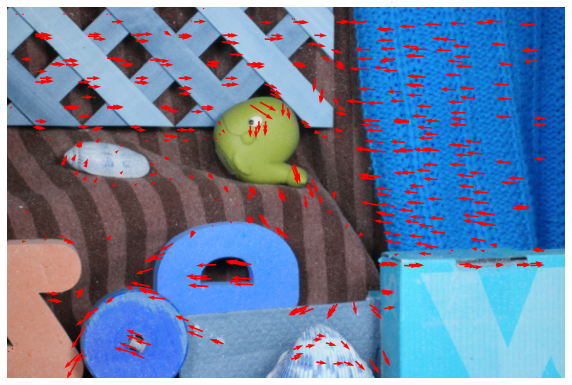

In [431]:
plt.figure(figsize=(10,10))
frame1 = cv2.imread('/content/frame07.png')
plt.imshow(frame1)
plt.quiver(X_deci, Y_deci, u_deci, v_deci, scale=15, scale_units='inches',color='red')
plt.axis('off')
plt.show()

In [392]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [393]:
"/content/drive/MyDrive/CV/assi2/Rubber Whale/1.jpg"

'/content/drive/MyDrive/CV/assi2/Rubber Whale/1.jpg'

In [394]:
folder_path='/content/drive/MyDrive/CV/assi2/Rubber Whale'
image = [ i for i in os.listdir(folder_path) ]
for i in range(len(image)):
    filename=folder_path + str(i+1) + '.jpg'
    print(filename)

/content/drive/MyDrive/CV/assi2/Rubber Whale1.jpg
/content/drive/MyDrive/CV/assi2/Rubber Whale2.jpg
/content/drive/MyDrive/CV/assi2/Rubber Whale3.jpg
/content/drive/MyDrive/CV/assi2/Rubber Whale4.jpg
/content/drive/MyDrive/CV/assi2/Rubber Whale5.jpg
/content/drive/MyDrive/CV/assi2/Rubber Whale6.jpg
/content/drive/MyDrive/CV/assi2/Rubber Whale7.jpg


In [395]:
def images_to_video(output_name,folder_path,frame_rate):
    image = [ i for i in os.listdir(folder_path) ]
    image_arr = []

    for i in range(len(image)):
        filename=folder_path + str(i+1) + '.jpg'
        img = cv2.imread(filename)
        rows, colums, layers = img.shape
        size = (rows,colums)
        image_arr.append(img)
        
    out = cv2.VideoWriter(output_name,cv2.VideoWriter_fourcc(*'DIVX'), frame_rate, size)
    for i in range(len(image_arr)):
        out.write(image_arr[i])
    out.release()
    

In [396]:
images_to_video('rubberwhale.mp4','/content/drive/MyDrive/CV/assi2/Rubber Whale/',20)

In [397]:
# Source:https://github.com/sampepose/flownet2-tf/blob/master/src/flowlib.py
import matplotlib.pyplot as plt
import numpy as np

UNKNOWN_FLOW_THRESH = 1e7
def show_flow(filename):
    """
    visualize optical flow map using matplotlib
    :param filename: optical flow file
    :return: None
    """
    flow = read_flow(filename)
    img = flow_to_image(flow)
    plt.imshow(img)
    plt.show()

def read_flow(filename):
    """
    read optical flow from Middlebury .flo file
    :param filename: name of the flow file
    :return: optical flow data in matrix
    """
    f = open(filename, 'rb')
    magic = np.fromfile(f, np.float32, count=1)
    data2d = None

    if 202021.25 != magic:
        print ('Magic number incorrect. Invalid .flo file')
    else:
        w = int(np.fromfile(f, np.int32, count=1)[0])
        h = int(np.fromfile(f, np.int32, count=1)[0])
        #print("Reading %d x %d flo file" % (h, w))
        data2d = np.fromfile(f, np.float32, count=2 * w * h)
        # reshape data into 3D array (columns, rows, channels)
        data2d = np.resize(data2d, (h, w, 2))
    f.close()
    return data2d

def flow_to_image(flow):
    """
    Convert flow into middlebury color code image
    :param flow: optical flow map
    :return: optical flow image in middlebury color
    """
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.

    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    maxu = max(maxu, np.max(u))
    minu = min(minu, np.min(u))

    maxv = max(maxv, np.max(v))
    minv = min(minv, np.min(v))

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(-1, np.max(rad))

    u = u/(maxrad + np.finfo(float).eps)
    v = v/(maxrad + np.finfo(float).eps)

    img = compute_color(u, v)

    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return u,v,np.uint8(img)


def compute_color(u, v):
    """
    compute optical flow color map
    :param u: optical flow horizontal map
    :param v: optical flow vertical map
    :return: optical flow in color code
    """
    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)

    rad = np.sqrt(u**2+v**2)

    a = np.arctan2(-v, -u) / np.pi

    fk = (a+1) / 2 * (ncols - 1) + 1

    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == ncols+1] = 1
    f = fk - k0

    for i in range(0, np.size(colorwheel,1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0-1] / 255
        col1 = tmp[k1-1] / 255
        col = (1-f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1-rad[idx]*(1-col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col*(1-nanIdx)))

    return img

def point_error(practical, theoretical):
    UNKNOWN_FLOW_THRESH = 1e7
    true_mask = np.ma.masked_where((abs(theoretical) < UNKNOWN_FLOW_THRESH), theoretical).mask
    corner_mask = np.ma.masked_where((abs(practical) != 0), practical).mask
    mask = true_mask & corner_mask
    result=np.linalg.norm(practical[mask] - theoretical[mask])
    return result


def make_color_wheel():
    """
    Generate color wheel according Middlebury color code
    :return: Color wheel
    """
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros([ncols, 3])

    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255*np.arange(0, RY) / RY))
    col += RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.transpose(np.floor(255*np.arange(0, YG) / YG))
    colorwheel[col:col+YG, 1] = 255
    col += YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.transpose(np.floor(255*np.arange(0, GC) / GC))
    col += GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.transpose(np.floor(255*np.arange(0, CB) / CB))
    colorwheel[col:col+CB, 2] = 255
    col += CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.transpose(np.floor(255*np.arange(0, BM) / BM))
    col += + BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col:col+MR, 0] = 255

    return colorwheel



Text(0.5, 1.0, 'Vertical optical flow')

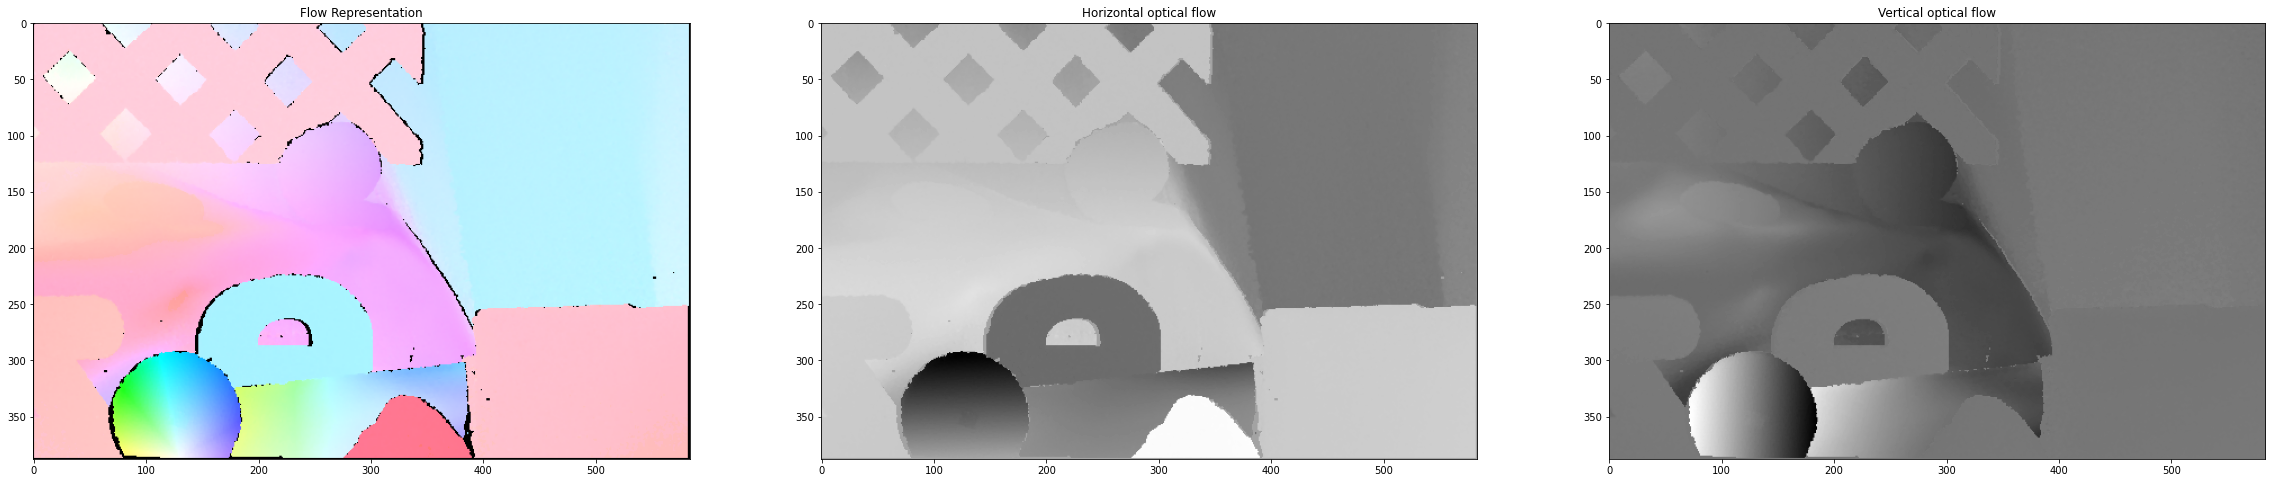

In [398]:
f = plt.figure()
f.set_figwidth(40)
f.set_figheight(20)

ground_truth = read_flow('/content/flow10.flo')
hori,verti,image=flow_to_image(ground_truth)
plt.subplot(131)
plt.imshow(image, cmap = 'hsv')
plt.title('Flow Representation')

plt.subplot(132)
plt.imshow(hori, cmap = 'gray')
plt.title('Horizontal optical flow')

plt.subplot(133)
plt.imshow(verti, cmap = 'gray')
plt.title('Vertical optical flow')



In [399]:
output = u,v
output= np.int0(output)
output = np.transpose(output, (1,2,0))
mat = read_flow('/content/flow10.flo')
print("The Average End Point Error  for Rubber Whale is : ", point_error(output, mat))

The Average End Point Error  for Rubber Whale is :  36.815409485650434


# 3

In [400]:
def OpticalFlowRefine(Img1, Img2, windowSize, u0, v0):
    u, v = np.zeros_like(u0), np.zeros_like(v0)
    offset = windowSize[0] // 2
    for i in range(offset, Img1.shape[0] - offset):
        for j in range(offset, Img1.shape[1] - offset):
            if u0[i, j] == 0 and v0[i, j] == 0:
                continue
            img1 = Img1[i - offset : i + offset + 1, j - offset : j + offset + 1]
            row_indices = [i - offset + v0[i, j], i + offset + v0[i, j]]
            col_indices = [j - offset + u0[i, j], j + offset + u0[i, j]]
 
 
            if row_indices[0] < 0:
                row_indices = [0, 2*offset]
            if row_indices[1] > Img1.shape[0] - 1:
                row_indices = [Img1.shape[0] - windowSize[0], Img1.shape[0] - 1]
            if col_indices[0] < 0:
                col_indices = [0, 2*offset]
            if col_indices[1] > Img1.shape[1] - 1:
                col_indices = [Img1.shape[1] - windowSize[0], Img1.shape[1] - 1]
 
 
            row_indices = list(map(int, row_indices))
            col_indices = list(map(int, col_indices))
 
            # shift img2
            img2 = Img2[row_indices[0]: row_indices[1] + 1, col_indices[0]: col_indices[1] + 1]
            del_u, del_v = LukasKanadeForwardAdditive(img1, img2, windowSize)
            u[i, j], v[i, j] = u0[i, j] + del_u[offset, offset], v0[i, j] + del_v[offset, offset]
            u[i, j], v[i, j] = del_u[offset, offset], del_v[offset, offset]
 
    return u, v

In [401]:
def down(Img):
    Img = gaussian_filter(Img, 1)
    return Img[::2, ::2]
 
def up(Img):
    img = np.zeros((Img.shape[0], 2*Img.shape[1]))
    res_img = np.zeros((2*Img.shape[0], 2*Img.shape[1]))
    img[:, ::2] = Img
    res_img[::2, :] = img
    return gaussian_filter(res_img, 1)
 
def MultiScaleLucasKanade(Img1, Img2, windowSize, numLevels, iters):
    pyramid1 = np.empty((*Img1.shape, numLevels))
    pyramid2 = np.empty((*Img1.shape, numLevels))    
 
    pyramid1[:, :, 0], pyramid2[:, :, 0] = Img1.copy(), Img2.copy()
 
 
    # Step 01. Gaussian smooth and scale Img1 and Img2 by a factor of 2ˆ(1 - numLevels)
    for floor in range(1, numLevels):
        Img1, Img2 = down(Img1), down(Img2)
        pyramid1[:Img1.shape[0], :Img1.shape[1], floor] = Img1
        pyramid2[:Img2.shape[0], :Img2.shape[1], floor] = Img2
 
 
    f = 2**(numLevels - 1)
    base1 = pyramid1[:Img1.shape[0]//f, :Img1.shape[1]//f]
    base2 = pyramid1[:Img2.shape[0]//f, :Img2.shape[1]//f]
 
    # Step 02. Compute the optical flow at this resolution.
    u, v = LukasKanadeForwardAdditive(Img1, Img2, windowSize)
    for _ in range(iters):
        u, v = OpticalFlowRefine(Img1, Img2, windowSize, u, v)
 
    for i in range(1, numLevels):
        uxx = 2 *  cv2.resize(u, None, fx=2, fy=2 ) # gayssuan
        uxx = up(u)
        vxx = 2 *  cv2.resize(v, None, fx=2, fy=2 )
        vxx = up(v)
 
        f = 2**(numLevels - i)
        img1 = pyramid1[:pyramid1.shape[0]//f, :pyramid1.shape[1]//f, numLevels - i]
        img2 = pyramid2[:pyramid2.shape[0]//f, :pyramid2.shape[1]//f, numLevels - i]
 
        u, v = OpticalFlowRefine(img1, img2, windowSize, uxx, vxx)
        for _ in range(iters):
            u, v = OpticalFlowRefine(img1, img2, windowSize, u, v)
 
    return u, v

In [422]:
def LukasKanadeForwardAdditive(Img1, Img2, windowSize):
    threshold=0.01

    w = windowSize # windowSize is odd, all the pixels with offset in between [-w, w] are inside the window
    Img1 = Img1 / 255. # normalize pixels
    Img2 = Img2 / 255. # normalize pixels
    # Implement Lucas Kanade
    # for each point, calculate I_x, I_y, I_t

    mode = 'same'
    x_kern = np.array([[-1., 1.], [-1., 1.]])
    y_kern = np.array([[-1., -1.], [1., 1.]])
    z_kern = np.array([[1., 1.], [1., 1.]])*2
    fx = signal.convolve2d(Img1, x_kern, boundary='symm', mode=mode)
    fy = signal.convolve2d(Img1, y_kern, boundary='symm', mode=mode)
    fz = signal.convolve2d(Img2, z_kern, boundary='symm', mode=mode) +  signal.convolve2d(Img1, -z_kern, boundary='symm', mode=mode)
    u = np.zeros(Img1.shape)
    v = np.zeros(Img1.shape)
    # within window windowSize * windowSize
    num=500
    corners = tomasi_detector(Img1,15)
    x = np.array(corners)
    yy=np.ndarray.flatten(x)
    for c in range(num):
      i=yy[c]
      j=yy[c+num]
      Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
      Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
      It = fz[i-w:i+w+1, j-w:j+w+1].flatten()
      b = np.reshape(It, (It.shape[0],1))
      A = np.vstack((Ix, Iy)).T 
      ata=np.matmul(A.T, A)
      eigen=np.linalg.eigvals(ata)
      threshold=0.01
      if np.min(abs(eigen)) >= threshold:
        nu = np.matmul(np.linalg.pinv(A), b) # get velocity here
        u[i,j]=nu[0]
        v[i,j]=nu[1]

    return (u,v)

In [423]:

frame1 = cv2.imread('/content/frame07.png')
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
frame2 = cv2.imread('/content/frame08.png')
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
ROWS, cor = tomasi_detector(frame1,15)
Du,v=MultiScaleLucasKanade(frame1, frame2, 3, 10, 30):
u,v = LukasKanadeForwardAdditive((frame1), (frame2), 15)

n, m = u.shape
u_deci = u[ROWS, cor]
v_deci = v[ROWS, cor]
[X,Y] = np.meshgrid(np.arange(m, dtype = 'float64'), np.arange(n, dtype = 'float64'))
X_deci = X[ROWS, cor]
Y_deci = Y[ROWS, cor]

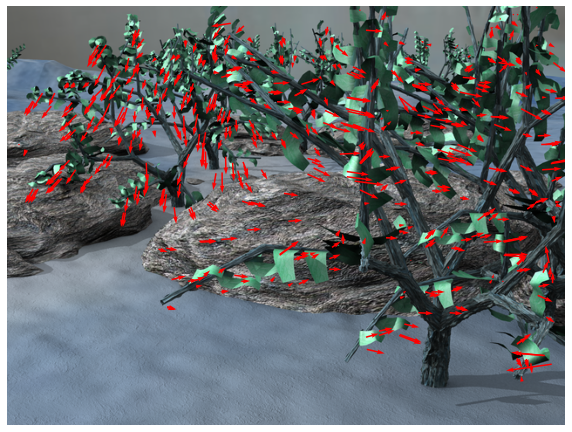

In [424]:
plt.figure(figsize=(10,10))
frame1 = cv2.imread('/content/frame07.png')
plt.imshow(frame1)
plt.quiver(X_deci, Y_deci, u_deci, v_deci, scale=10, scale_units='inches',color='red')
plt.axis('off')
plt.show()